Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

In [6]:
import pandas as pd
import scipy
import numpy as np
from scipy import stats
from scipy.stats  import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

sns.set (
    font_scale =2,
    style = 'whitegrid',
    rc= {'figure.figsize': (15,7)}
)
from tqdm.auto import tqdm

In [13]:
def get_nday_retention(n,sorting='users'): 
    df_reg_data = pd.read_csv('/home/jupyter-k.bataeva-14/shared/problem1-reg_data.csv', sep = ';')
    df_auth_data = pd.read_csv('/home/jupyter-k.bataeva-14/shared/problem1-auth_data.csv', sep = ';')

    #Добавляю колонку с временем в формате даты; в частности, в дф с регистрацией добавляю когорту
    df_reg_data['cohorts_by_day'] = pd.to_datetime(df_reg_data.reg_ts,  unit='s').dt.date 
    df_reg_data['cohorts_by_day'] = pd.to_datetime(df_reg_data['cohorts_by_day'])
    df_auth_data['date'] = pd.to_datetime(df_auth_data.auth_ts, unit='s').dt.date
    df_auth_data['date']  = pd.to_datetime(df_auth_data['date'] )

    #Объединяю дф, чтобы получить полный со всеми датами
    df_full = df_reg_data.merge(df_auth_data, on= 'uid').drop(columns = ['reg_ts','auth_ts'] ).sort_values(by = 'cohorts_by_day')

    df_full = df_full.query('cohorts_by_day> "2019-01-01"') #так как пример учебный и дф слишком тяжёлый, беру только часть

    df_cohorts_by_day=df_full.cohorts_by_day.drop_duplicates() # список когорт по дням

    #формирование когорт!
    freq= 'D'
    rol_retention = 0
    df_cohorts_final = pd.DataFrame(columns = ['cohorts', 'users', 'n_day','n_day_retention', 'n_day_rolling_retention']) #дф на вывод 
    for cohort in df_cohorts_by_day:
        df_cohort = df_full.query('cohorts_by_day == @cohort')
        cohort_size =df_cohort.uid.nunique() 
        n_date = cohort+ pd.Timedelta(n, unit=freq) #считаю n day дату
        retention = round(((df_cohort.drop_duplicates(subset = ['date', 'uid']).query('date == @n_date').date.count()  /cohort_size) * 100), 1)
        for i in range(1,n+1): # цикл для подсчета rolling retention
            n_date_rolling = cohort+ pd.Timedelta(i, unit=freq)
            rol_retention = rol_retention + round(((df_cohort.drop_duplicates(subset = ['date', 'uid']).query('date == @n_date_rolling').date.count()  / cohort_size) * 100), 1)
        df_cohorts_final = df_cohorts_final.append({'cohorts': cohort, 'users': cohort_size,'n_day': n , 'n_day_retention': retention,'n_day_rolling_retention' : rol_retention}, ignore_index=True)
        rol_retention = 0
    df_cohorts_final = df_cohorts_final.sort_values(by = sorting, ascending = False)  
    return df_cohorts_final

In [15]:
get_nday_retention(2, sorting = 'cohorts')

,cohorts,users,n_day,n_day_retention,n_day_rolling_retention
630,2020-09-23,1048,2,0.0,0.0
629,2020-09-22,1641,2,0.0,0.9
628,2020-09-21,1638,2,3.0,4.9
627,2020-09-20,1636,2,4.3,6.7
626,2020-09-19,1634,2,3.5,5.3
...,...,...,...,...,...
4,2019-01-06,588,2,3.7,5.4
3,2019-01-05,586,2,4.1,6.0
2,2019-01-04,585,2,3.8,6.5
1,2019-01-03,585,2,3.1,4.8


### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Что ж, первым делом хочется посмотреть на сами данные, особенно на распределение платящих в обеих группах. ARPU - это, конечно, хорошо, но учитывая, что в выборках много неплатящих пользователей, следует посмотреть ещё 
##### ARPPU и CR в покупателя.

Читаю данные, смотрю их свойства:

In [9]:
df_ab_test = pd.read_csv('/home/jupyter-k.bataeva-14/final_project/Проект_1_Задание_2.csv', sep = ';')
df_ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [58]:
df_ab_test.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [10]:
df_ab_test.shape

(404770, 3)

In [11]:
df_ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [12]:
df_ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [13]:
df_ab_test.user_id.nunique()

404770

Хочется узнать, есть ли стат значимая разница между количеством платящих в тестовой и контрольной группах


In [14]:
pd.crosstab(columns = df_ab_test.revenue >0, index =  df_ab_test.testgroup)

revenue,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [15]:
chi2, p, dof, expected =  chi2_contingency(pd.crosstab(columns = df_ab_test. testgroup, index = df_ab_test.revenue >0 ))
print(chi2, p, dof, expected)

4.374729521260405 0.03647561892312613 1 [[200239.10075104 200797.89924896]
 [  1863.89924896   1869.10075104]]


#### Вывод:
Взаимосвязь между группой и количеством платящих есть.

Далее посмотрим на распределения платящих в обеих группах!

In [17]:
def normality_test(df):       #для проверки нормальности
    s = stats.shapiro(df)
    return s, df.hist()

In [19]:
df_a= df_ab_test.query('testgroup == "a" & revenue > 0')
df_b= df_ab_test.query('testgroup == "b" & revenue > 0')

In [62]:
df_a.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [63]:
df_b.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


In [64]:
df_b.revenue.sum()

5421603

In [65]:
df_a.revenue.sum()

5136189

(ShapiroResult(statistic=0.2667924761772156, pvalue=0.0),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64eb169dd8>)

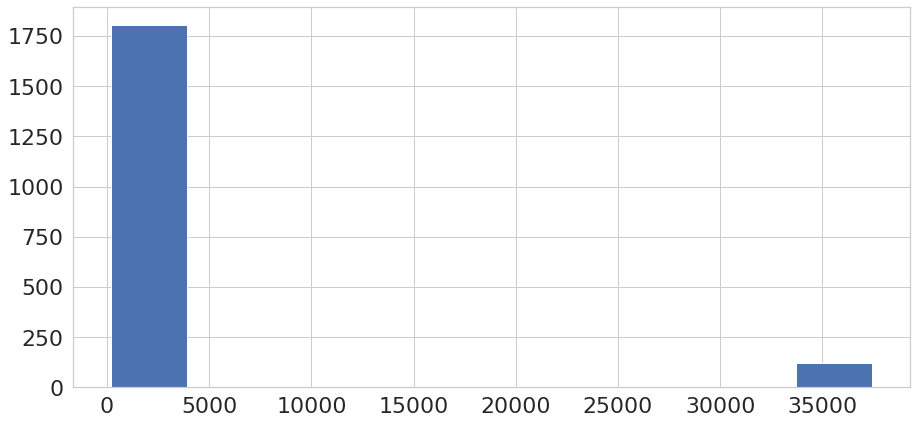

In [20]:
normality_test(df_a.revenue)

(ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64eb0949e8>)

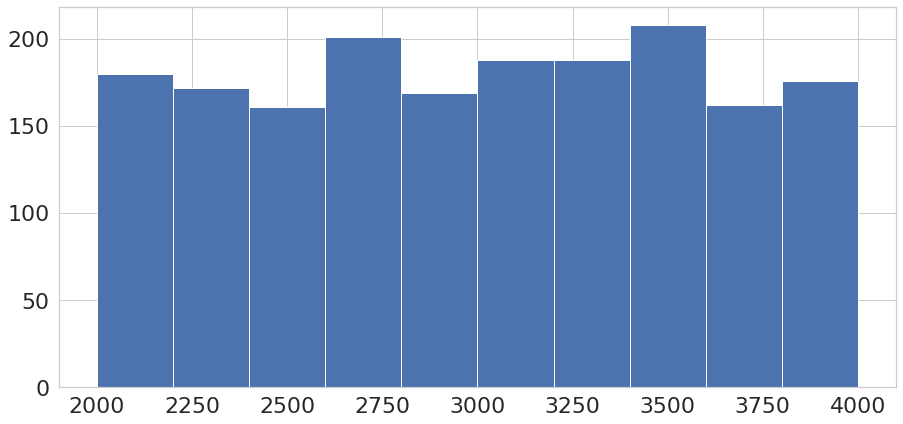

In [21]:
normality_test(df_b.revenue)

Оба распределения не являются нормальными: об этом говорят и графики, и Шапиро. В контрольной группе больший разброс - есть небольшая группа пользователей, которая сделала покупку в районе 35к рублей, так и люди, заплатившие в районе 200. У экспериментальной группы разброс от 2000 до 4000.

Для статистической проверки в таком случае можно применить критерий Манна-Уитни:

In [22]:
stats.mannwhitneyu(df_a.revenue, df_b.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

#### Вывод:
Распределение дохода от платящих в группе а и группе б статистически значимо различается.

In [23]:
df_a.revenue.median()

311.0

In [24]:
df_b.revenue.median()

3022.0

Далее мне стало интересно посмотреть на бутстрап, так как для данных распределений нельзя применить классических критериев. Зная, что критерий Манна-Уитни говорит о разности распределений, можно сразу предположить, что будет статистически значимая разница в медианах среди платящих. Но что насчёт средних?

In [25]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    # нам нужно сравнять количество наблюдений в обоих выборках, чтобы метод сработал
    boot_len = max([len(data_column_1), len(data_column_2)])
    # пустой список, в который будет записано нужное нам распределение
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    # рассчитываем доверительный интервал. Если 0 не попадает в ДИ, отклоняем H0  
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    # так как нас интересуют значения выше нуля  
    p_value = min( sum(pd_boot_data < 0), sum(pd_boot_data > 0) ) * 2 / len(pd_boot_data)
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

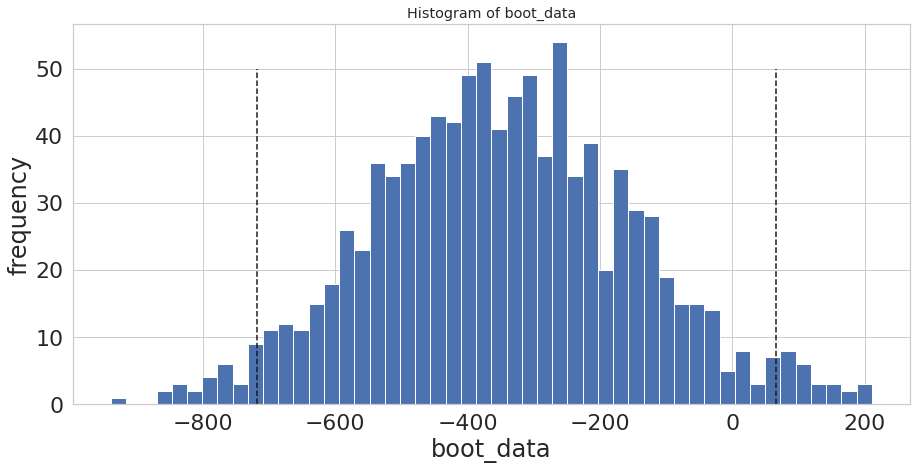

In [26]:
booted_data_mean = get_bootstrap(df_a.revenue, df_b.revenue, statistic = np.mean)

In [52]:
booted_data_mean['ci']

,0
0.025,-718.694308
0.975,65.722199


In [28]:
booted_data_mean['p_value']

0.0

#### Вывод
Согласно методу бутстрап средние(ARPPU) не различаются, 0 входит в интервал, p<0.01

Посмотрим на медианы!

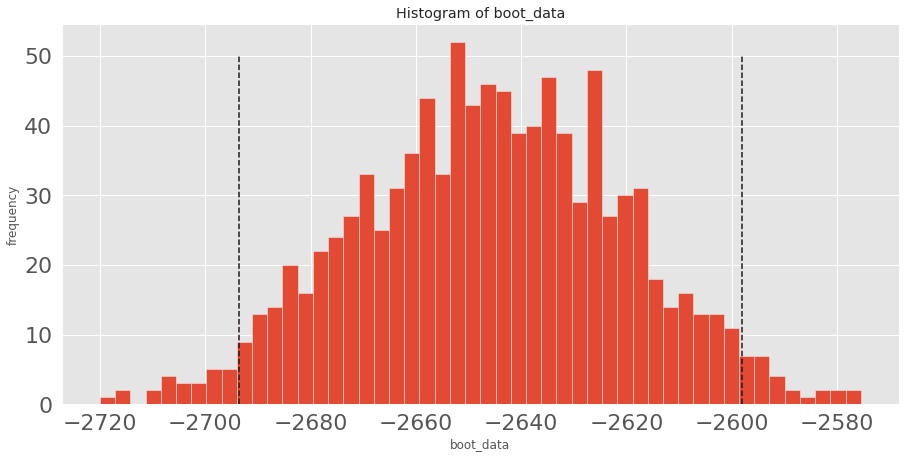

In [29]:
booted_data_median = get_bootstrap(df_a.revenue, df_b.revenue, statistic = np.median)

In [56]:
booted_data_median['ci']

,0
0.025,-2693.5125
0.975,-2598.0000


In [31]:
booted_data_median['p_value']

0.0

In [55]:
booted_data_median['ci'].diff()

,0
0.025,NaN
0.975,95.5125


#### Вывод
Согласно методу бутстрап средние тестовой и контрольной групп не различаются(0 входит в интервал, p<0.01), но медианы различаются(0 не входит в интервал, p<0.01). Различие между медианами доходит до 95.5 рублей.

Теперь мне даже стало интересно, что получили предыдущие исследователи и каким образом. Этот бутстрап я провожу на выборке со всеми пользователями, включая неплавтивших

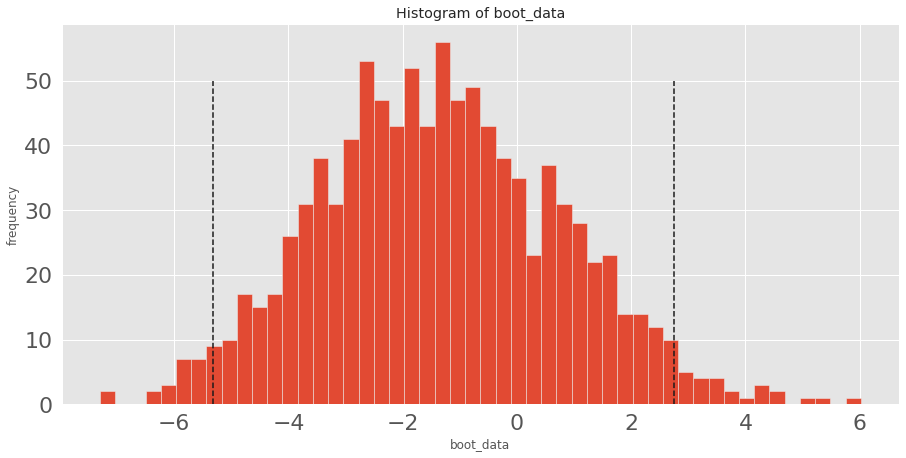

In [35]:
booted_data_mean2 = get_bootstrap(df_ab_test.query('testgroup == "a"').revenue, df_ab_test.query('testgroup == "b"').revenue, statistic = np.mean)

,0
0.025,-5.646841
0.975,3.329553


In [34]:
booted_data_mean2['p_value']

0.0

Интересно получается! Согласно бутстрап, разницы между а и б группой по среднему чеку(ARPU) нет! 0 Входит в интервал, p<0.01

### Общий вывод

Во-первых, стоит отметить, что не удалось получить результата предыдущего исследования по ARPU - метод бутстрап не показал статистически значимых различий в экпериментальной и контрольной группах по этой метрике. Да и стоит отметить, что ARPU явно недостаточен, так как есть огромное количество пользователей(> 75%), которые не заплатили.

Что касается ARPPU - здесь различий по средним тоже нет, зато нашлось значимое различие по медиане - величина эффекта до 100 рублей.

И, наконец, конверсия в покупателя(CR) в тестовой группе статистически значимо меньше, чем в контрольной.

Решение, которое следует принять: оставить акционные предложения А. У них есть статистически значимое влияние на CR по сравнению с группой B, по остальным метрикам(ARPU, ARPPU), не выявлено значимого эффекта ни у одной группы.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Решение:
Для первого условия:

- Метрики времени
Так как для получения награды требуется тратить больше времени в игре, первая метрика, которая приходит в голову - retention. Заинтресованный игрок будет чаще заходить в приложение, больше времени тратить в игре, чтобы добить награду. Сюда же можно отнести такие метрики как DAU, MAU(а лучше его аналог на период, в который длится эвент), ASD, которые тоже напрямую связаны со временем и вовлечённостью пользователя.


- Метрики прибыли
Учитывая то, что нередко игроку не хватает буквально несколько кристалликов или алмазиков, чтобы получить желанный сезонный предмет, можно предположить, что за период акции возрастет количество платящих пользователей, следует обратить внимание на следующие метрики: ARPU, ARPPU, LTV


- Отток пользователей
Churn rate на время эвента может снизиться, так как в игре происходит что-то новое. Можно сравить его как с предыдущими эвентами, так и с периодом вне эвентов(если он есть)

Для второго условия:

Перед перечислением метрик хотела бы описать общий взгляд на ситуацию. Хочу сказать, что считаю, что такое развитие событий слабо повлияет на неплатящих игроков. Если они сначала и постараются играть на таких условиях, скорее всего большая часть из них сдастся после первых неудач. Они не станут платить за то, что не получается. По поводу платящих сказать сложнее.

- Метрики времени
Retention, DAU, MAU(а лучше его аналог на период, в который длится эвент), ASD. 

- Метрики прибыли
ARPPU. Предполагаю, что платящие продолжат платить. А может быть расстроятся и не станут. В любом случае, полезно посмотреть.

- Отток пользователей
Churn rate на время эвента может увеличиться из-за неудач с игрой, так что тоже стоит обратить внимание.